# Testing the Model

This Jupyter Notebook contains some testing done for the machine learning model that will be used for the project.

## Setting Up

First, we need to extract the features from the `binary-features.txt` file.

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

NUM_FEATURES = 16

X = np.genfromtxt("binary-features.txt", delimiter=",", usecols=np.arange(NUM_FEATURES), skip_header=1)
y = np.genfromtxt("binary-features.txt", delimiter=",", usecols=NUM_FEATURES, skip_header=1)

In [2]:
unique, counts = np.unique(y, return_counts=True)
for i in range(0, len(unique)):
    print(f"{unique[i]}: {counts[i]}")

0.0: 7
1.0: 5
3.0: 9
4.0: 9
5.0: 6
6.0: 12
8.0: 6
10.0: 5
11.0: 7
12.0: 6
13.0: 19
14.0: 8
15.0: 7
16.0: 5
17.0: 6
18.0: 7
19.0: 8
20.0: 6
23.0: 10
24.0: 5
25.0: 6
27.0: 7
28.0: 8
29.0: 8
30.0: 5
31.0: 5
32.0: 5
33.0: 5
35.0: 9
37.0: 12
39.0: 5
40.0: 8
41.0: 12
42.0: 7
43.0: 10
45.0: 7
47.0: 7
50.0: 7
51.0: 7
52.0: 9
53.0: 8
54.0: 6
55.0: 7
57.0: 8
58.0: 13
59.0: 5
61.0: 6
62.0: 5
63.0: 5
65.0: 7
66.0: 5
68.0: 24
69.0: 5
72.0: 7
74.0: 6
75.0: 5
76.0: 6
77.0: 9
78.0: 7
79.0: 5
80.0: 8
81.0: 13
83.0: 7
84.0: 12
86.0: 5
88.0: 8
89.0: 9
90.0: 7
91.0: 8
92.0: 7
93.0: 8
94.0: 5
96.0: 11
99.0: 7
101.0: 10
102.0: 7
104.0: 11
105.0: 14
106.0: 7
107.0: 10
108.0: 7
109.0: 8
110.0: 8
113.0: 15
114.0: 7
115.0: 7
116.0: 5
117.0: 7
119.0: 6
120.0: 6
121.0: 22
122.0: 9
123.0: 6
124.0: 5
125.0: 15
126.0: 6
127.0: 5
128.0: 6
129.0: 9
130.0: 14
131.0: 5
133.0: 5
134.0: 7
135.0: 7
136.0: 5
138.0: 7
139.0: 5
140.0: 5
141.0: 5
142.0: 7
143.0: 8
146.0: 6
147.0: 6
148.0: 9
149.0: 9
150.0: 8
151.0: 9
152.0: 5


## Getting Train and Test Sets

Now we have a set of features and a set of labels, we can get the training and testing sets using `sklearn`'s `train_test_split` function.

In [3]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2408, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Choosing a Model

To try and get the best model for the task of binary authorship attribution, we must determine the type of problem we face. Because we are trying to predict a class given a set of features, we need to use **classification** models. We can also fine-tune the models to get the best parameters.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import time

X_train_pr, X_valid, y_train_pr, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)


pipelines_and_grids = {
    "KNN": (
        Pipeline([
            ("scaler", StandardScaler()),
            ("clf", KNeighborsClassifier())
        ]),
        {
            "clf__n_neighbors": [3, 5, 7, 9, 11],
            "clf__weights": ["uniform", "distance"],
            "clf__p": [1, 2],  # Manhattan / Euclidean
        }
    ),

    "SVC": (
        Pipeline([
            ("scaler", StandardScaler()),
            ("clf", SVC())
        ]),
        {
            "clf__C": [0.01, 0.1, 1, 10, 100],
            "clf__gamma": ["scale", "auto", 0.01, 0.1, 1],
            "clf__kernel": ["rbf"],
        }
    ),

    "LogisticRegression": (
        Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=2000))
        ]),
        {
            "clf__C": [0.01, 0.1, 1, 10, 100],
            "clf__penalty": ["l2"],
            "clf__solver": ["lbfgs"],
        }
    ),

    "GradientBoosting": (
        GradientBoostingClassifier(),
        {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [2, 3, 4],
        }
    ),

    "RandomForest": (
        RandomForestClassifier(class_weight="balanced"),
        {
            "n_estimators": [200, 500],
            "max_depth": [4, 6, 8, None],
            "max_features": ["sqrt", "log2"],
            "criterion": ["gini", "entropy"],
        }
    ),
}

results = {}

for name, (model, grid) in pipelines_and_grids.items():
    print(f"\n🔍 Tuning {name}...")

    grid_search = GridSearchCV(
        model,
        grid,
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    start = time.time()
    grid_search.fit(X_train_pr, y_train_pr)
    elapsed = time.time() - start

    best_model = grid_search.best_estimator_
    accuracy = best_model.score(X_valid, y_valid)

    print(f"Best Params: {grid_search.best_params_}")
    print(f"Best CV Score: {grid_search.best_score_:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Time: {elapsed:.2f}s")

    results[name] = {
        "best_model": best_model,
        "best_params": grid_search.best_params_,
        "cv_score": grid_search.best_score_,
        "val_accuracy": accuracy,
        "training_time": elapsed,
    }

Tuning SVC using cross-validation...

Training KNN...
KNN Accuracy: 0.2213

Training SVC...
{'C': 500, 'gamma': 0.01}
0.3579439252336448
SVC Accuracy: 0.4314

Training LogisticRegression...
LogisticRegression Accuracy: 0.1905

Training RandomForest...
RandomForest Accuracy: 0.4314


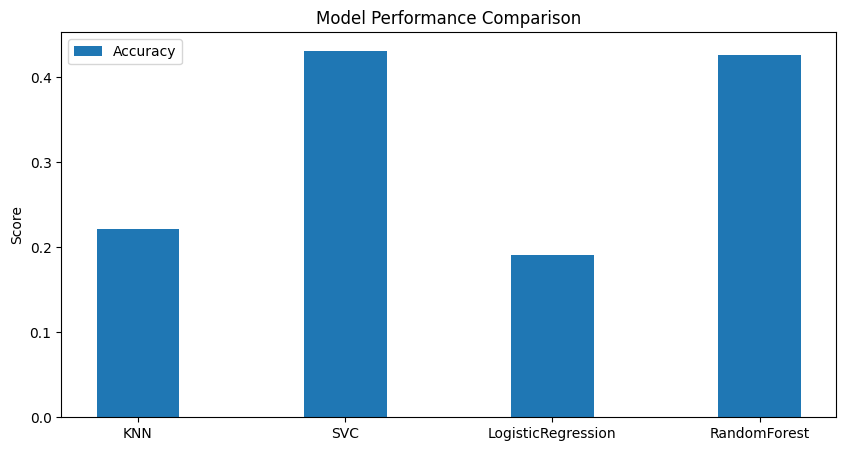

In [13]:
import matplotlib.pyplot as plt

model_names = list(results.keys())
accuracies = [results[m]["accuracy"] for m in model_names]
speeds = [results[m]["time"] for m in model_names]

plt.figure(figsize=(10,5))
x = np.arange(len(model_names))

plt.bar(x, accuracies, width=0.4, label="Accuracy")


plt.xticks(x, model_names)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()

plt.show()